In [1]:
import os
import re
from launcher_tools import logger

regex = ".*football-\d*D-KMEANS.*"
directory_list = list()
for root, dirs, files in os.walk("RESULTS", topdown=False):
    for name in dirs:
        if re.search(regex, name) is not None:
            directory_list.append(os.path.join(root, name))

In [6]:
import torch
def get_values(regex):
    size = [2,3,4,5,10]
    size_inv = {2:0,3:1,4:2,5:3,10:4}
    MEANS = [0,0,0,0,0]
    VAR =[0,0,0,0,0]
    RES = [[],[],[],[],[]]
    STD_KM = [[],[],[],[],[]]
    directory_list = list()
    for root, dirs, files in os.walk("RESULTS", topdown=False):
        for name in dirs:
            if re.search(regex, name) is not None:
                directory_list.append(os.path.join(root, name))
    
    for i in directory_list:
        print(i)
        log = logger.JSONLogger(i+"/log.json", mod="continue")

        #         print(log)
        #         print(MEANS)
        RES[size_inv[log["size"]]] += log["kmeans_from_embeddings"]["RES"]
        STD_KM[size_inv[log["size"]]] += log["kmeans_from_embeddings"]["STD_KMEANS"]
    res = torch.Tensor(RES)
    std_km = torch.Tensor(STD_KM)
    print(res.size())
    print(res[torch.arange(5),std_km.min(-1)[1]])
    best_res_var = res[torch.arange(5),std_km.min(-1)[1]]
    return res.mean(-1).tolist(), res.std(-1).tolist() ,size, std_km.tolist() , best_res_var.tolist()

In [7]:
MEANS_A, VAR_A, SIZE_A, STD_KM_A , BEST_A= get_values("dblp-\d*D-KMEANS.*")
MEANS_B, VAR_B, SIZE_B, STD_KM_B , BEST_B= get_values(".*dblp-euclidean.*-KMEANS.*")

RESULTS/dblp-2D-KMEANS-1
RESULTS/dblp-5D-KMEANS-1
RESULTS/dblp-4D-KMEANS-1


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [20]:
print(BEST)

[4.945209980010986, 5.08145809173584, 5.8397979736328125, 6.5045576095581055]


<IPython.core.display.Javascript object>


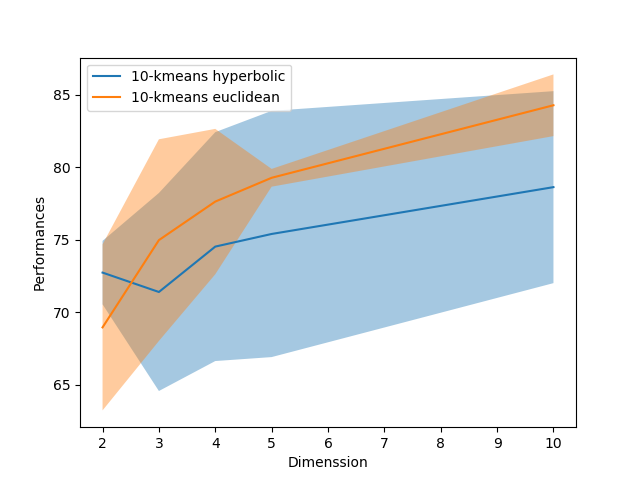

In [10]:
from matplotlib import pyplot as plt
%matplotlib nbagg
import numpy as np
size = SIZE_A
var = np.array(VAR_A)
mean = np.array(MEANS_A)
plt.plot(size, MEANS_A, label="10-kmeans hyperbolic")
plt.ylabel("Performances")
plt.xlabel("Dimenssion")
plt.fill_between(size, mean-var, mean+var, alpha=0.4)

var = np.array(VAR_B)
mean = np.array(MEANS_B)
plt.plot(size, MEANS_B, label="10-kmeans euclidean")
plt.fill_between(size, mean-var, mean+var, alpha=0.4)
plt.legend()


In [61]:
def table_latex(sizes, means, var, best, eu_means, eu_var, best_eu):
    mstr="\\begin{table} \n \t \centering \n \t \\begin{tabular}{|c|cc|cc|}\n"
    mstr+= "\t\t\hline Dimension & performance hyperbolic & min var hyperbolic &  performance euclidean & min var euclidean\\\\ \hline\n"
    
    for size, mean, std, mv, e_mean, e_std, e_mv in zip(sizes, means, var, best, eu_means, eu_var, best_eu):
        mean, std, mv, e_mean, e_std, e_mv = mean*10//1/10, std*10//1/10, mv*10//1/10, e_mean*10//1/10, e_std*10//1/10, e_mv *10//1/10
        mstr+="\t\t"+str(size)+"& $"+str(mean)+" \pm "+str(std)+"$ & "+str(mv)+"& $"+str(e_mean)+" \pm "+str(e_std)+"$&"+str(e_mv)+"\\\\ \hline\n"
    mstr+="\t\end{tabular}\n \end{table}"
    return mstr
    

In [62]:
print(table_latex(size, MEANS_A, VAR_A, BEST_A, MEANS_B, VAR_B, BEST_B))

\begin{table} 
 	 \centering 
 	 \begin{tabular}{|c|cc|cc|}
		\hline Dimension & performance hyperbolic & min var hyperbolic &  performance euclidean & min var euclidean\\ \hline
		2& $74.5 \pm 3.4$ & 70.4& $77.8 \pm 3.8$&80.9\\ \hline
		3& $78.0 \pm 3.8$ & 81.9& $76.5 \pm 3.5$&79.0\\ \hline
		4& $77.8 \pm 3.3$ & 80.0& $79.3 \pm 2.5$&79.0\\ \hline
		5& $77.2 \pm 2.2$ & 85.7& $78.5 \pm 1.9$&79.0\\ \hline
		10& $79.9 \pm 4.0$ & 84.7& $78.1 \pm 4.1$&81.9\\ \hline
	\end{tabular}
 \end{table}
